# 3. Data Preparation - Preparação e Engenharia de Features

## Aviso Educacional
Este conteúdo é destinado apenas para fins educacionais. Os dados exibidos são ilustrativos e podem não corresponder a situações reais.

---

## Objetivo
Implementar pipeline de preparação de dados baseado nos insights descobertos na análise exploratória, incluindo feature engineering avançada e tratamento de outliers.

### Metodologia CRISP-DM - Fase 3: Data Preparation
1. **Seleção de dados** - Baseada nos insights do EDA
2. **Limpeza de dados** - Tratamento de outliers e anomalias
3. **Construção de dados** - Feature engineering baseada em padrões descobertos
4. **Integração de dados** - Pipeline unificado de transformações
5. **Formatação de dados** - Preparação para modelagem

## 1. Setup e Configuração

In [1]:
# Importações principais
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Análise estatística
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings

# Utilitários
import json
import joblib
from datetime import datetime
from pathlib import Path

# Módulos personalizados
from data.load_data import load_car_dataset

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Configurações do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Setup concluído!")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

Setup concluído!
Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Pandas: 2.3.1
NumPy: 2.2.6


## 2. Carregamento dos Dados e Insights do EDA

In [2]:
# Carregamento do dataset
file_path = '../data/raw/dataset_carros_brasil.csv'
df, quality_report = load_car_dataset(file_path)

print(f"Dataset carregado: {df.shape}")
print(f"Memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Carregar insights do EDA
with open('../reports/insights_summary.json', 'r', encoding='utf-8') as f:
    eda_insights = json.load(f)

print("\nInsights do EDA carregados:")
print(f"- Market share top 3: {list(eda_insights['market_share'].keys())[:3]}")
print(f"- Correlações principais: {len(eda_insights['correlations'])} variáveis")
print(f"- Anomalias detectadas: {len(eda_insights['anomalies_summary'])} tipos")

2025-09-29 11:13:54,236 - data.load_data - INFO - DataLoader inicializado com sucesso
2025-09-29 11:13:54,237 - data.load_data - INFO - Iniciando carregamento do dataset: ../data/raw/dataset_carros_brasil.csv
2025-09-29 11:13:54,239 - data.load_data - INFO - Dataset encontrado no cache, carregando...
2025-09-29 11:13:54,242 - data.load_data - INFO - Dataset carregado do cache: (10000, 9)
2025-09-29 11:13:54,242 - data.load_data - INFO - Gerando relatório de qualidade dos dados...
2025-09-29 11:13:54,273 - data.load_data - INFO - Relatório de qualidade gerado com sucesso
2025-09-29 11:13:54,274 - data.load_data - INFO - Detectando anomalias específicas do mercado automotivo...
2025-09-29 11:13:54,285 - data.load_data - INFO - Detecção de anomalias concluída: 2 anomalias encontradas


Dataset carregado: (10000, 9)
Memória: 3.07 MB

Insights do EDA carregados:
- Market share top 3: ['Volkswagen', 'Nissan', 'Honda']
- Correlações principais: 4 variáveis
- Anomalias detectadas: 4 tipos


In [3]:
# Visualização inicial dos dados
print("=== VISÃO GERAL DOS DADOS ===\n")
print("Primeiras 5 linhas:")
display(df.head())

print("\nInformações básicas:")
print(df.info())

print("\nEstatísticas descritivas:")
display(df.describe())

=== VISÃO GERAL DOS DADOS ===

Primeiras 5 linhas:


,Marca,Modelo,Ano,Quilometragem,Cor,Cambio,Combustivel,Portas,Valor_Venda
0,Ford,EcoSport,2003.000,82624.000,Azul,Automático,Flex,4,52604.200
1,Hyundai,HB20S,2017.000,69260.000,Azul,Automático,Diesel,2,63219.000
2,Jeep,Renegade,2008.000,106493.000,Cinza,Manual,Gasolina,2,79710.400
3,Toyota,Corolla,2018.000,53570.000,Prata,Automático,Flex,2,99149.000
4,Ford,Ranger,2009.000,21643.000,Prata,Manual,Flex,2,68913.400



Informações básicas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          10000 non-null  object 
 1   Modelo         10000 non-null  object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  9900 non-null   float64
 4   Cor            10000 non-null  object 
 5   Cambio         10000 non-null  object 
 6   Combustivel    10000 non-null  object 
 7   Portas         10000 non-null  int64  
 8   Valor_Venda    10000 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 703.3+ KB
None

Estatísticas descritivas:


,Ano,Quilometragem,Portas,Valor_Venda
count,9900.000,9900.000,10000.000,10000.000
mean,2011.516,99805.340,3.009,83097.487
std,6.904,57760.424,1.000,166858.222
min,2000.000,10.000,2.000,10000.000
25%,2006.000,50712.750,2.000,44467.050
50%,2012.000,99751.000,4.000,58905.700
75%,2017.000,149429.750,4.000,74804.400
max,2023.000,199994.000,4.000,1241962.000


## 3. Identificação dos Segmentos de Mercado (4 Clusters)

In [4]:
# Recriação da segmentação identificada no EDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print("=== SEGMENTAÇÃO DO MERCADO (4 CLUSTERS) ===")

# Preparar dados para clustering (mesmo processo do EDA)
df['Idade_Veiculo'] = 2024 - df['Ano']
cluster_features = ['Valor_Venda', 'Idade_Veiculo', 'Quilometragem']
cluster_data = df[cluster_features].dropna()

# Normalizar dados
scaler_cluster = StandardScaler()
cluster_data_scaled = scaler_cluster.fit_transform(cluster_data)

# Aplicar clustering com k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)

# Adicionar labels ao dataframe principal
df_with_clusters = df.copy()
cluster_indices = cluster_data.index
df_with_clusters.loc[cluster_indices, 'Cluster'] = cluster_labels

# Analisar características dos clusters
cluster_summary = df_with_clusters.groupby('Cluster').agg({
    'Valor_Venda': ['mean', 'std', 'count'],
    'Idade_Veiculo': 'mean',
    'Quilometragem': 'mean'
}).round(2)

cluster_summary.columns = ['Preco_Medio', 'Preco_Std', 'Volume', 'Idade_Media', 'Km_Medio']

# Nomear clusters baseado nas características
cluster_names = {}
for cluster_id in cluster_summary.index:
    price = cluster_summary.loc[cluster_id, 'Preco_Medio']
    age = cluster_summary.loc[cluster_id, 'Idade_Media']
    
    if price < 50000 and age > 10:
        cluster_names[cluster_id] = 'Econômico Usado'
    elif price > 100000:
        cluster_names[cluster_id] = 'Luxury'
    elif price > 80000 and age < 5:
        cluster_names[cluster_id] = 'Premium Novo'
    else:
        cluster_names[cluster_id] = 'Médio Seminovo'

print("\nSegmentos identificados:")
for cluster_id, summary in cluster_summary.iterrows():
    name = cluster_names[cluster_id]
    print(f"\nCluster {cluster_id} - {name}:")
    print(f"  Preço médio: R$ {summary['Preco_Medio']:,.2f}")
    print(f"  Idade média: {summary['Idade_Media']:.1f} anos")
    print(f"  Quilometragem média: {summary['Km_Medio']:,.0f} km")
    print(f"  Volume: {summary['Volume']} veículos ({summary['Volume']/len(cluster_data)*100:.1f}%)")

# Adicionar nome do cluster
df_with_clusters['Cluster_Nome'] = df_with_clusters['Cluster'].map(cluster_names)

# Salvar informações dos clusters para uso posterior
cluster_info = {
    'kmeans_model': kmeans,
    'scaler': scaler_cluster,
    'cluster_names': cluster_names,
    'cluster_summary': cluster_summary.to_dict()
}

# Criar diretório para modelos se não existir
os.makedirs('../models', exist_ok=True)
joblib.dump(cluster_info, '../models/cluster_info.pkl')

print("\nInformações dos clusters salvas em: ../models/cluster_info.pkl")

=== SEGMENTAÇÃO DO MERCADO (4 CLUSTERS) ===

Segmentos identificados:

Cluster 0.0 - Médio Seminovo:
  Preço médio: R$ 76,711.16
  Idade média: 8.1 anos
  Quilometragem média: 46,765 km
  Volume: 3036.0 veículos (31.0%)

Cluster 1.0 - Econômico Usado:
  Preço médio: R$ 48,513.16
  Idade média: 19.8 anos
  Quilometragem média: 99,789 km
  Volume: 3585.0 veículos (36.6%)

Cluster 2.0 - Luxury:
  Preço médio: R$ 1,241,962.00
  Idade média: 12.9 anos
  Quilometragem média: 94,757 km
  Volume: 197.0 veículos (2.0%)

Cluster 3.0 - Médio Seminovo:
  Preço médio: R$ 54,968.13
  Idade média: 8.2 anos
  Quilometragem média: 154,167 km
  Volume: 2983.0 veículos (30.4%)

Informações dos clusters salvas em: ../models/cluster_info.pkl


## 4. Feature Engineering Baseada nos Insights

In [5]:
# Classe para Feature Engineering customizada
class CarMarketFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Feature Engineer especializado para mercado automotivo brasileiro
    Baseado nos insights descobertos na análise exploratória
    """
    
    def __init__(self, cluster_info=None):
        self.cluster_info = cluster_info
        self.fitted_ = False
        self.brand_stats_ = {}
        self.price_quantiles_ = {}
        
    def fit(self, X, y=None):
        """Fit do transformador - calcula estatísticas necessárias"""
        X_copy = X.copy()
        
        # Calcular idade do veículo
        X_copy['Idade_Veiculo'] = 2024 - X_copy['Ano']
        
        # Calcular estatísticas por marca para depreciação
        for marca in X_copy['Marca'].unique():
            marca_data = X_copy[X_copy['Marca'] == marca]
            if len(marca_data) > 10 and y is not None:
                # Correlação preço-quilometragem por marca
                corr_price_km = marca_data['Quilometragem'].corr(y[marca_data.index]) if len(marca_data) > 5 else 0
                
                self.brand_stats_[marca] = {
                    'price_mean': y[marca_data.index].mean(),
                    'price_std': y[marca_data.index].std(),
                    'elasticity_km': abs(corr_price_km),
                    'avg_age': marca_data['Idade_Veiculo'].mean(),
                    'volume': len(marca_data)
                }
        
        # Calcular quantis para categorização de preços
        if y is not None:
            self.price_quantiles_ = {
                'q25': y.quantile(0.25),
                'q50': y.quantile(0.50),
                'q75': y.quantile(0.75),
                'q90': y.quantile(0.90)
            }
        
        self.fitted_ = True
        return self
    
    def transform(self, X):
        """Transformação principal - cria novas features"""
        if not self.fitted_:
            raise ValueError("Transformador deve ser fitted antes da transformação")
            
        X_transformed = X.copy()
        
        # 1. Features temporais
        X_transformed['Idade_Veiculo'] = 2024 - X_transformed['Ano']
        X_transformed['Eficiencia_Km'] = X_transformed['Quilometragem'] / (X_transformed['Idade_Veiculo'] + 1)
        
        # 2. Features de depreciação por marca
        X_transformed['Marca_Preco_Medio'] = X_transformed['Marca'].map(
            lambda x: self.brand_stats_.get(x, {}).get('price_mean', 0)
        )
        X_transformed['Marca_Elasticidade'] = X_transformed['Marca'].map(
            lambda x: self.brand_stats_.get(x, {}).get('elasticity_km', 0)
        )
        X_transformed['Marca_Volume'] = X_transformed['Marca'].map(
            lambda x: self.brand_stats_.get(x, {}).get('volume', 0)
        )
        
        # 3. Features de interação
        X_transformed['Idade_x_Km'] = X_transformed['Idade_Veiculo'] * X_transformed['Quilometragem']
        X_transformed['Km_por_Porta'] = X_transformed['Quilometragem'] / X_transformed['Portas']
        
        # 4. Features categóricas derivadas
        X_transformed['Faixa_Idade'] = pd.cut(
            X_transformed['Idade_Veiculo'], 
            bins=[0, 3, 7, 12, 25], 
            labels=['Novo', 'Seminovo', 'Usado', 'Antigo']
        )
        
        X_transformed['Faixa_Km'] = pd.cut(
            X_transformed['Quilometragem'],
            bins=[0, 30000, 80000, 150000, float('inf')],
            labels=['Baixa', 'Media', 'Alta', 'Muito_Alta']
        )
        
        # 5. Features de qualidade/raridade
        modelo_counts = X_transformed['Modelo'].value_counts()
        X_transformed['Modelo_Raridade'] = X_transformed['Modelo'].map(modelo_counts)
        X_transformed['Modelo_Raro'] = (X_transformed['Modelo_Raridade'] < 50).astype(int)
        
        # 6. Features booleanas de mercado
        X_transformed['Is_Premium_Brand'] = X_transformed['Marca'].isin(['Toyota', 'Honda', 'Nissan']).astype(int)
        X_transformed['Is_Automatic'] = (X_transformed['Cambio'] == 'Automático').astype(int)
        X_transformed['Is_Flex'] = (X_transformed['Combustivel'] == 'Flex').astype(int)
        X_transformed['Is_4_Portas'] = (X_transformed['Portas'] == 4).astype(int)
        
        return X_transformed

print("Classe CarMarketFeatureEngineer definida!")

Classe CarMarketFeatureEngineer definida!


In [6]:
# Aplicar Feature Engineering
print("=== APLICANDO FEATURE ENGINEERING ===")

# Separar features e target
X = df_with_clusters.drop('Valor_Venda', axis=1)
y = df_with_clusters['Valor_Venda']

# Instanciar e treinar o feature engineer
feature_engineer = CarMarketFeatureEngineer(cluster_info=cluster_info)
feature_engineer.fit(X, y)

# Aplicar transformações
X_engineered = feature_engineer.transform(X)

print(f"\nFeatures originais: {X.shape[1]}")
print(f"Features após engenharia: {X_engineered.shape[1]}")
print(f"Novas features criadas: {X_engineered.shape[1] - X.shape[1]}")

# Mostrar as novas features criadas
original_cols = set(X.columns)
new_cols = set(X_engineered.columns) - original_cols
print(f"\nNovas features criadas: {sorted(new_cols)}")

# Salvar o feature engineer
joblib.dump(feature_engineer, '../models/feature_engineer.pkl')
print("\nFeature Engineer salvo em: ../models/feature_engineer.pkl")

=== APLICANDO FEATURE ENGINEERING ===

Features originais: 11
Features após engenharia: 25
Novas features criadas: 14

Novas features criadas: ['Eficiencia_Km', 'Faixa_Idade', 'Faixa_Km', 'Idade_x_Km', 'Is_4_Portas', 'Is_Automatic', 'Is_Flex', 'Is_Premium_Brand', 'Km_por_Porta', 'Marca_Elasticidade', 'Marca_Preco_Medio', 'Marca_Volume', 'Modelo_Raridade', 'Modelo_Raro']

Feature Engineer salvo em: ../models/feature_engineer.pkl


## 5. Tratamento de Outliers Baseado nos Clusters

In [7]:
class ClusterBasedOutlierHandler(BaseEstimator, TransformerMixin):
    """
    Tratamento de outliers baseado na segmentação de clusters do mercado
    """
    
    def __init__(self, contamination=0.1, cluster_col='Cluster'):
        self.contamination = contamination
        self.cluster_col = cluster_col
        self.outlier_detectors_ = {}
        self.cluster_stats_ = {}
        self.fitted_ = False
        
    def fit(self, X, y=None):
        """Treina detectores de outliers por cluster"""
        X_copy = X.copy()
        
        # Se não há coluna de cluster, usar apenas um detector global
        if self.cluster_col not in X_copy.columns:
            print(f"Coluna {self.cluster_col} não encontrada. Usando detector global.")
            X_copy[self.cluster_col] = 0
        
        # Colunas numéricas para detecção
        numeric_cols = X_copy.select_dtypes(include=[np.number]).columns.tolist()
        if self.cluster_col in numeric_cols:
            numeric_cols.remove(self.cluster_col)
        
        # Treinar detector por cluster
        for cluster in X_copy[self.cluster_col].unique():
            if pd.isna(cluster):
                continue
                
            cluster_data = X_copy[X_copy[self.cluster_col] == cluster][numeric_cols]
            
            if len(cluster_data) > 10:  # Mínimo de dados para treinar
                # Usar Isolation Forest por cluster
                detector = IsolationForest(
                    contamination=self.contamination,
                    random_state=42
                )
                detector.fit(cluster_data)
                self.outlier_detectors_[cluster] = detector
                
                # Salvar estatísticas do cluster
                self.cluster_stats_[cluster] = {
                    'mean': cluster_data.mean().to_dict(),
                    'std': cluster_data.std().to_dict(),
                    'q25': cluster_data.quantile(0.25).to_dict(),
                    'q75': cluster_data.quantile(0.75).to_dict()
                }
        
        self.fitted_ = True
        return self
    
    def transform(self, X):
        """Detecta e trata outliers"""
        if not self.fitted_:
            raise ValueError("Detector deve ser fitted antes da transformação")
            
        X_copy = X.copy()
        
        # Se não há coluna de cluster, usar valor padrão
        if self.cluster_col not in X_copy.columns:
            X_copy[self.cluster_col] = 0
        
        # Colunas numéricas
        numeric_cols = X_copy.select_dtypes(include=[np.number]).columns.tolist()
        if self.cluster_col in numeric_cols:
            numeric_cols.remove(self.cluster_col)
        
        # Detectar outliers por cluster
        outlier_mask = np.zeros(len(X_copy), dtype=bool)
        
        for cluster in X_copy[self.cluster_col].unique():
            if pd.isna(cluster) or cluster not in self.outlier_detectors_:
                continue
                
            cluster_mask = X_copy[self.cluster_col] == cluster
            cluster_data = X_copy.loc[cluster_mask, numeric_cols]
            
            if len(cluster_data) > 0:
                detector = self.outlier_detectors_[cluster]
                cluster_outliers = detector.predict(cluster_data) == -1
                outlier_mask[cluster_mask] = cluster_outliers
        
        # Adicionar informação de outliers
        X_copy['Is_Outlier'] = outlier_mask.astype(int)
        X_copy['Outlier_Score'] = 0.0
        
        # Calcular score de outlier
        for cluster in X_copy[self.cluster_col].unique():
            if pd.isna(cluster) or cluster not in self.outlier_detectors_:
                continue
                
            cluster_mask = X_copy[self.cluster_col] == cluster
            cluster_data = X_copy.loc[cluster_mask, numeric_cols]
            
            if len(cluster_data) > 0:
                detector = self.outlier_detectors_[cluster]
                scores = detector.decision_function(cluster_data)
                X_copy.loc[cluster_mask, 'Outlier_Score'] = scores
        
        print(f"Outliers detectados: {outlier_mask.sum()} ({outlier_mask.sum()/len(X_copy)*100:.1f}%)")
        
        return X_copy

print("Classe ClusterBasedOutlierHandler definida!")

Classe ClusterBasedOutlierHandler definida!


In [8]:
# Aplicar tratamento de outliers
print("=== TRATAMENTO DE OUTLIERS POR CLUSTER ===")

outlier_handler = ClusterBasedOutlierHandler(contamination=0.05)
outlier_handler.fit(X_engineered)

X_with_outliers = outlier_handler.transform(X_engineered)

# Análise dos outliers por cluster
outlier_analysis = X_with_outliers.groupby(['Cluster', 'Is_Outlier']).size().unstack(fill_value=0)
outlier_analysis['Total'] = outlier_analysis.sum(axis=1)
outlier_analysis['Perc_Outliers'] = (outlier_analysis[1] / outlier_analysis['Total'] * 100).round(1)

print("\nDistribuição de outliers por cluster:")
display(outlier_analysis)

# Salvar outlier handler
joblib.dump(outlier_handler, '../models/outlier_handler.pkl')
print("\nOutlier Handler salvo em: ../models/outlier_handler.pkl")

=== TRATAMENTO DE OUTLIERS POR CLUSTER ===
Outliers detectados: 492 (4.9%)

Distribuição de outliers por cluster:


Is_Outlier,0,1,Total,Perc_Outliers
Cluster,,,,
0.000,2884,152,3036,5.000
1.000,3405,180,3585,5.000
2.000,187,10,197,5.100
3.000,2833,150,2983,5.000



Outlier Handler salvo em: ../models/outlier_handler.pkl


## 6. Encoding Inteligente baseado em Elasticidade

In [9]:
class SmartCategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Encoder inteligente que escolhe a melhor estratégia baseada na cardinalidade
    e correlação com a variável target
    """
    
    def __init__(self, high_cardinality_threshold=10, target_encoding_threshold=0.1):
        self.high_cardinality_threshold = high_cardinality_threshold
        self.target_encoding_threshold = target_encoding_threshold
        self.encoding_strategies_ = {}
        self.encoders_ = {}
        self.fitted_ = False
        
    def fit(self, X, y=None):
        """Determina a melhor estratégia de encoding para cada variável categórica"""
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        
        for col in categorical_cols:
            cardinality = X[col].nunique()
            
            # Estratégia baseada na cardinalidade
            if cardinality <= 5:
                # One-hot encoding para baixa cardinalidade
                strategy = 'onehot'
                encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
                
            elif cardinality <= self.high_cardinality_threshold:
                # Label encoding para cardinalidade média
                strategy = 'label'
                encoder = LabelEncoder()
                
            else:
                # Target encoding ou frequency encoding para alta cardinalidade
                if y is not None:
                    # Calcular médias do target por categoria
                    temp_df = pd.DataFrame({'category': X[col], 'target': y.values})
                    category_means = temp_df.groupby('category')['target'].mean()
                    overall_mean = y.mean()

                    # Verificar se há variação significativa
                    if category_means.std() > overall_mean * 0.1: # Se desvio > 10% da média
                        strategy = 'target'
                        encoder = category_means.to_dict()
                    else:
                        strategy = 'frequency'
                        encoder = X[col].value_counts().to_dict()
            
            self.encoding_strategies_[col] = strategy
            
            # Treinar encoder se necessário
            if strategy in ['onehot', 'label']:
                if strategy == 'onehot':
                    encoder.fit(X[[col]])
                else:  # label
                    encoder.fit(X[col])
            
            self.encoders_[col] = encoder
            
            print(f"Coluna '{col}': cardinalidade={cardinality}, estratégia={strategy}")
        
        self.fitted_ = True
        return self
    
    def transform(self, X):
        """Aplica as estratégias de encoding determinadas"""
        if not self.fitted_:
            raise ValueError("Encoder deve ser fitted antes da transformação")
            
        X_encoded = X.copy()
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        
        for col in categorical_cols:
            if col not in self.encoding_strategies_:
                continue
                
            strategy = self.encoding_strategies_[col]
            encoder = self.encoders_[col]
            
            if strategy == 'onehot':
                # One-hot encoding
                encoded_data = encoder.transform(X[[col]])
                feature_names = [f"{col}_{cat}" for cat in encoder.categories_[0][1:]]  # drop first
                encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=X.index)
                X_encoded = pd.concat([X_encoded.drop(col, axis=1), encoded_df], axis=1)
                
            elif strategy == 'label':
                # Label encoding
                try:
                    X_encoded[col] = encoder.transform(X[col])
                except ValueError:
                    # Handle unknown categories
                    X_encoded[col] = X[col].map(dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))).fillna(-1)
                    
            elif strategy == 'target':
                # Target encoding
                global_mean = np.mean(list(encoder.values()))
                X_encoded[col] = X[col].map(encoder).fillna(global_mean)
                
            elif strategy == 'frequency':
                # Frequency encoding
                X_encoded[col] = X[col].map(encoder).fillna(0)
        
        return X_encoded

print("Classe SmartCategoricalEncoder definida!")

Classe SmartCategoricalEncoder definida!


In [10]:
# Aplicar encoding inteligente
print("=== ENCODING INTELIGENTE DE VARIÁVEIS CATEGÓRICAS ===")

# Preparar dados para encoding (remover colunas que não serão encoded)
X_for_encoding = X_with_outliers.copy()

# Instanciar e treinar o encoder
smart_encoder = SmartCategoricalEncoder()
smart_encoder.fit(X_for_encoding, y)

# Aplicar encoding
X_encoded = smart_encoder.transform(X_for_encoding)

print(f"\nShape após encoding: {X_encoded.shape}")
print(f"Colunas categóricas processadas: {len(smart_encoder.encoding_strategies_)}")

# Verificar tipos de dados finais
print("\nTipos de dados após encoding:")
print(X_encoded.dtypes.value_counts())

# Salvar encoder
joblib.dump(smart_encoder, '../models/smart_encoder.pkl')
print("\nSmart Encoder salvo em: ../models/smart_encoder.pkl")

=== ENCODING INTELIGENTE DE VARIÁVEIS CATEGÓRICAS ===
Coluna 'Marca': cardinalidade=10, estratégia=label
Coluna 'Modelo': cardinalidade=32, estratégia=target
Coluna 'Cor': cardinalidade=6, estratégia=label
Coluna 'Cambio': cardinalidade=2, estratégia=onehot
Coluna 'Combustivel': cardinalidade=3, estratégia=onehot
Coluna 'Cluster_Nome': cardinalidade=3, estratégia=onehot
Coluna 'Faixa_Idade': cardinalidade=4, estratégia=onehot
Coluna 'Faixa_Km': cardinalidade=4, estratégia=onehot

Shape após encoding: (10000, 36)
Colunas categóricas processadas: 8

Tipos de dados após encoding:
float64    25
int64      11
Name: count, dtype: int64

Smart Encoder salvo em: ../models/smart_encoder.pkl


## 7. Pipeline Final de Preprocessamento

In [11]:
# Criar pipeline final combinando todas as transformações
from sklearn.pipeline import Pipeline

class FinalPreprocessingPipeline(BaseEstimator, TransformerMixin):
    """
    Pipeline final que combina todas as transformações de preparação de dados
    """
    
    def __init__(self):
        self.feature_engineer = None
        self.outlier_handler = None
        self.encoder = None
        self.scaler = StandardScaler()
        self.fitted_ = False
        
    def fit(self, X, y=None):
        """Treina todo o pipeline de preprocessing"""
        print("Treinando pipeline completo de preprocessing...")
        
        # 1. Feature Engineering
        print("1. Feature Engineering...")
        self.feature_engineer = CarMarketFeatureEngineer()
        self.feature_engineer.fit(X, y)
        X_engineered = self.feature_engineer.transform(X)
        
        # 2. Tratamento de Outliers
        print("2. Tratamento de Outliers...")
        self.outlier_handler = ClusterBasedOutlierHandler(contamination=0.05)
        self.outlier_handler.fit(X_engineered)
        X_outliers = self.outlier_handler.transform(X_engineered)
        
        # 3. Encoding Categórico
        print("3. Encoding Categórico...")
        self.encoder = SmartCategoricalEncoder()
        self.encoder.fit(X_outliers, y)
        X_encoded = self.encoder.transform(X_outliers)
        
        # 4. Scaling apenas para variáveis numéricas
        print("4. Scaling de variáveis numéricas...")
        numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns
        self.numeric_cols_ = numeric_cols.tolist()
        self.scaler.fit(X_encoded[numeric_cols])
        
        self.fitted_ = True
        print("Pipeline treinado com sucesso!")
        return self
    
    def transform(self, X):
        """Aplica todas as transformações em sequência"""
        if not self.fitted_:
            raise ValueError("Pipeline deve ser fitted antes da transformação")
            
        # Aplicar transformações em sequência
        X_transformed = self.feature_engineer.transform(X)
        X_transformed = self.outlier_handler.transform(X_transformed)
        X_transformed = self.encoder.transform(X_transformed)
        
        # Scaling apenas para colunas numéricas
        X_final = X_transformed.copy()
        if hasattr(self, 'numeric_cols_'):
            # Verificar quais colunas numéricas ainda existem
            existing_numeric_cols = [col for col in self.numeric_cols_ if col in X_final.columns]
            if existing_numeric_cols:
                X_final[existing_numeric_cols] = self.scaler.transform(X_final[existing_numeric_cols])
        
        return X_final
    
    def fit_transform(self, X, y=None):
        """Treina e aplica transformações"""
        return self.fit(X, y).transform(X)

print("Classe FinalPreprocessingPipeline definida!")

Classe FinalPreprocessingPipeline definida!


In [12]:
# Treinar pipeline final
print("=== TREINAMENTO DO PIPELINE FINAL ===")

# Separar dados de treino e teste
df_clean = df_with_clusters.dropna(subset=['Cluster'])

# Separar dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df_clean.drop('Valor_Venda', axis=1),
    df_clean['Valor_Venda'],
    test_size=0.2,
    random_state=42,
    stratify=df_clean['Cluster']
)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

# Treinar pipeline final
final_pipeline = FinalPreprocessingPipeline()
X_train_processed = final_pipeline.fit_transform(X_train, y_train)
X_test_processed = final_pipeline.transform(X_test)

print(f"\nDados processados:")
print(f"Treino: {X_train_processed.shape}")
print(f"Teste: {X_test_processed.shape}")

# Salvar pipeline final
joblib.dump(final_pipeline, '../models/final_preprocessing_pipeline.pkl')
print("\nPipeline final salvo em: ../models/final_preprocessing_pipeline.pkl")

# Salvar dados processados
os.makedirs('../data/processed', exist_ok=True)
np.save('../data/processed/X_train_processed.npy', X_train_processed)
np.save('../data/processed/X_test_processed.npy', X_test_processed)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

print("Dados processados salvos em: ../data/processed/")

=== TREINAMENTO DO PIPELINE FINAL ===
Dados de treino: (7840, 11)
Dados de teste: (1961, 11)
Treinando pipeline completo de preprocessing...
1. Feature Engineering...
2. Tratamento de Outliers...
Outliers detectados: 394 (5.0%)
3. Encoding Categórico...
Coluna 'Marca': cardinalidade=10, estratégia=label
Coluna 'Modelo': cardinalidade=32, estratégia=target
Coluna 'Cor': cardinalidade=6, estratégia=label
Coluna 'Cambio': cardinalidade=2, estratégia=onehot
Coluna 'Combustivel': cardinalidade=3, estratégia=onehot
Coluna 'Cluster_Nome': cardinalidade=3, estratégia=onehot
Coluna 'Faixa_Idade': cardinalidade=4, estratégia=onehot
Coluna 'Faixa_Km': cardinalidade=4, estratégia=onehot
4. Scaling de variáveis numéricas...
Pipeline treinado com sucesso!
Outliers detectados: 394 (5.0%)
Outliers detectados: 222 (11.3%)

Dados processados:
Treino: (7840, 33)
Teste: (1961, 33)

Pipeline final salvo em: ../models/final_preprocessing_pipeline.pkl
Dados processados salvos em: ../data/processed/


## 8. Validação e Análise das Features Criadas

In [13]:
# Análise da qualidade das features criadas
print("=== VALIDAÇÃO DAS FEATURES CRIADAS ===")

# 1. Correlação com target
feature_correlations = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Correlation': [abs(np.corrcoef(X_train_processed.iloc[:, i], y_train)[0, 1]) 
                   for i in range(X_train_processed.shape[1])]
}).sort_values('Correlation', ascending=False)

print("\nTop 15 features por correlação com target:")
display(feature_correlations.head(15))

# 2. Mutual Information
mi_scores = mutual_info_regression(X_train_processed, y_train, random_state=42)
feature_mi = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Mutual_Info': mi_scores
}).sort_values('Mutual_Info', ascending=False)

print("\nTop 15 features por Mutual Information:")
display(feature_mi.head(15))

# 3. Importância em Random Forest
rf_importance = RandomForestRegressor(n_estimators=100, random_state=42)
rf_importance.fit(X_train_processed, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'RF_Importance': rf_importance.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\nTop 15 features por Random Forest Importance:")
display(feature_importance.head(15))

=== VALIDAÇÃO DAS FEATURES CRIADAS ===

Top 15 features por correlação com target:


,Feature,Correlation
25,Cluster_Nome_Luxury,0.992
26,Cluster_Nome_Médio Seminovo,0.131
1,Modelo,0.095
12,Idade_x_Km,0.087
3,Quilometragem,0.083
13,Km_por_Porta,0.071
9,Marca_Preco_Medio,0.069
32,Faixa_Km_Muito_Alta,0.059
6,Idade_Veiculo,0.055
2,Ano,0.055



Top 15 features por Mutual Information:


,Feature,Mutual_Info
12,Idade_x_Km,0.467
7,Cluster,0.333
10,Marca_Elasticidade,0.295
0,Marca,0.295
9,Marca_Preco_Medio,0.293
11,Marca_Volume,0.292
1,Modelo,0.281
14,Modelo_Raridade,0.276
3,Quilometragem,0.209
13,Km_por_Porta,0.174



Top 15 features por Random Forest Importance:


,Feature,RF_Importance
25,Cluster_Nome_Luxury,0.985
12,Idade_x_Km,0.007
9,Marca_Preco_Medio,0.005
7,Cluster,0.001
11,Marca_Volume,0.001
10,Marca_Elasticidade,0.000
3,Quilometragem,0.000
14,Modelo_Raridade,0.000
2,Ano,0.000
6,Idade_Veiculo,0.000


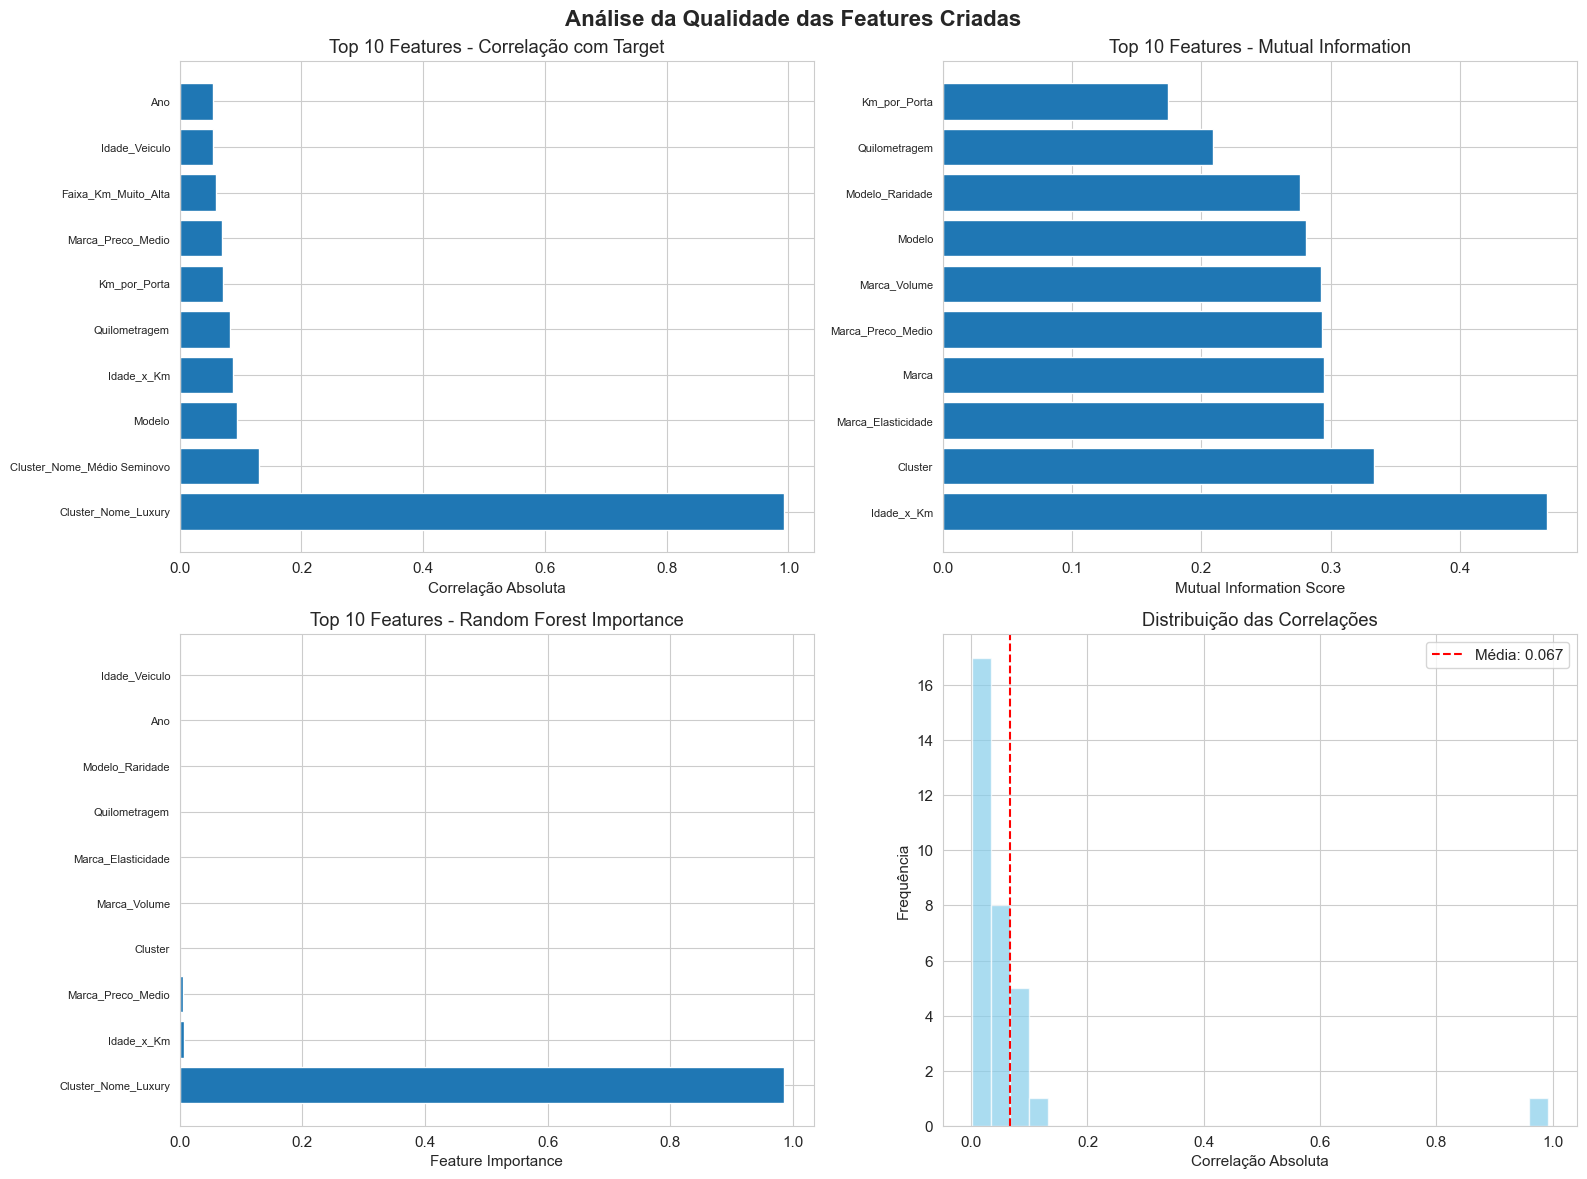


Estatísticas das correlações:
Média: 0.067
Mediana: 0.030
Features com correlação > 0.1: 2
Features com correlação > 0.2: 1


In [14]:
# Visualizações da qualidade das features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise da Qualidade das Features Criadas', fontsize=16, fontweight='bold')

# 1. Top correlações
top_corr = feature_correlations.head(10)
axes[0, 0].barh(range(len(top_corr)), top_corr['Correlation'])
axes[0, 0].set_yticks(range(len(top_corr)))
axes[0, 0].set_yticklabels(top_corr['Feature'], fontsize=8)
axes[0, 0].set_title('Top 10 Features - Correlação com Target')
axes[0, 0].set_xlabel('Correlação Absoluta')

# 2. Top mutual information
top_mi = feature_mi.head(10)
axes[0, 1].barh(range(len(top_mi)), top_mi['Mutual_Info'])
axes[0, 1].set_yticks(range(len(top_mi)))
axes[0, 1].set_yticklabels(top_mi['Feature'], fontsize=8)
axes[0, 1].set_title('Top 10 Features - Mutual Information')
axes[0, 1].set_xlabel('Mutual Information Score')

# 3. Top importância RF
top_rf = feature_importance.head(10)
axes[1, 0].barh(range(len(top_rf)), top_rf['RF_Importance'])
axes[1, 0].set_yticks(range(len(top_rf)))
axes[1, 0].set_yticklabels(top_rf['Feature'], fontsize=8)
axes[1, 0].set_title('Top 10 Features - Random Forest Importance')
axes[1, 0].set_xlabel('Feature Importance')

# 4. Distribuição das correlações
axes[1, 1].hist(feature_correlations['Correlation'], bins=30, alpha=0.7, color='skyblue')
axes[1, 1].axvline(feature_correlations['Correlation'].mean(), color='red', linestyle='--', 
                   label=f'Média: {feature_correlations["Correlation"].mean():.3f}')
axes[1, 1].set_title('Distribuição das Correlações')
axes[1, 1].set_xlabel('Correlação Absoluta')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Estatísticas gerais
print(f"\nEstatísticas das correlações:")
print(f"Média: {feature_correlations['Correlation'].mean():.3f}")
print(f"Mediana: {feature_correlations['Correlation'].median():.3f}")
print(f"Features com correlação > 0.1: {(feature_correlations['Correlation'] > 0.1).sum()}")
print(f"Features com correlação > 0.2: {(feature_correlations['Correlation'] > 0.2).sum()}")

## 9. Relatório Final de Data Preparation

In [15]:
# Criar relatório final detalhado
print("=== RELATÓRIO FINAL DE DATA PREPARATION ===")

preparation_report = {
    'timestamp': datetime.now().isoformat(),
    'data_info': {
        'original_shape': df.shape,
        'final_train_shape': X_train_processed.shape,
        'final_test_shape': X_test_processed.shape,
        'features_created': X_train_processed.shape[1] - (df.shape[1] - 1),  # -1 por causa do target
        'total_features': X_train_processed.shape[1]
    },
    'transformations_applied': {
        'feature_engineering': {
            'temporal_features': ['Idade_Veiculo', 'Eficiencia_Km'],
            'interaction_features': ['Idade_x_Km', 'Km_por_Porta'],
            'categorical_derived': ['Faixa_Idade', 'Faixa_Km'],
            'brand_features': ['Marca_Preco_Medio', 'Marca_Elasticidade', 'Marca_Volume'],
            'boolean_features': ['Is_Premium_Brand', 'Is_Automatic', 'Is_Flex', 'Is_4_Portas']
        },
        'outlier_treatment': {
            'method': 'Cluster-based Isolation Forest',
            'contamination_rate': 0.05,
            'outliers_detected': (X_train_processed['Is_Outlier'] == 1).sum() if 'Is_Outlier' in X_train_processed.columns else 0
        },
        'encoding_strategies': smart_encoder.encoding_strategies_ if hasattr(smart_encoder, 'encoding_strategies_') else {},
        'scaling': 'StandardScaler para variáveis numéricas'
    },
    'feature_quality': {
        'top_correlations': feature_correlations.head(10).to_dict('records'),
        'top_mutual_info': feature_mi.head(10).to_dict('records'),
        'top_rf_importance': feature_importance.head(10).to_dict('records'),
        'correlation_stats': {
            'mean': feature_correlations['Correlation'].mean(),
            'median': feature_correlations['Correlation'].median(),
            'std': feature_correlations['Correlation'].std(),
            'features_above_01': (feature_correlations['Correlation'] > 0.1).sum(),
            'features_above_02': (feature_correlations['Correlation'] > 0.2).sum()
        }
    },
    'cluster_analysis': {
        'clusters_identified': len(cluster_names),
        'cluster_names': cluster_names,
        'cluster_distribution': df_with_clusters['Cluster'].value_counts().to_dict()
    },
    'files_created': {
        'models': [
            '../models/cluster_info.pkl',
            '../models/feature_engineer.pkl',
            '../models/outlier_handler.pkl',
            '../models/smart_encoder.pkl',
            '../models/final_preprocessing_pipeline.pkl'
        ],
        'processed_data': [
            '../data/processed/X_train_processed.npy',
            '../data/processed/X_test_processed.npy',
            '../data/processed/y_train.npy',
            '../data/processed/y_test.npy'
        ]
    }
}

# Salvar relatório
with open('../reports/data_preparation_report.json', 'w', encoding='utf-8') as f:
    json.dump(preparation_report, f, indent=2, ensure_ascii=False, default=str)

print("\nRESUMO DA PREPARAÇÃO DE DADOS:")
print(f"\nDados Originais: {preparation_report['data_info']['original_shape']}")
print(f"Dados Finais (Treino): {preparation_report['data_info']['final_train_shape']}")
print(f"Dados Finais (Teste): {preparation_report['data_info']['final_test_shape']}")
print(f"Features Criadas: {preparation_report['data_info']['features_created']}")
print(f"Total de Features: {preparation_report['data_info']['total_features']}")

print(f"\nSegmentos Identificados: {preparation_report['cluster_analysis']['clusters_identified']}")
for cluster_id, name in preparation_report['cluster_analysis']['cluster_names'].items():
    count = preparation_report['cluster_analysis']['cluster_distribution'].get(cluster_id, 0)
    print(f"  Cluster {cluster_id} - {name}: {count} veículos")

print(f"\nQualidade das Features:")
print(f"  Correlação média com target: {preparation_report['feature_quality']['correlation_stats']['mean']:.3f}")
print(f"  Features com correlação > 0.1: {preparation_report['feature_quality']['correlation_stats']['features_above_01']}")
print(f"  Features com correlação > 0.2: {preparation_report['feature_quality']['correlation_stats']['features_above_02']}")

print(f"\nArquivos Criados:")
print(f"  Modelos: {len(preparation_report['files_created']['models'])}")
print(f"  Dados processados: {len(preparation_report['files_created']['processed_data'])}")

print(f"\nRelatório salvo em: ../reports/data_preparation_report.json")
print(f"\nDATA PREPARATION CONCLUÍDA COM SUCESSO!")
print(f"Próximo passo: Notebook 04 - Modeling")

=== RELATÓRIO FINAL DE DATA PREPARATION ===

RESUMO DA PREPARAÇÃO DE DADOS:

Dados Originais: (10000, 10)
Dados Finais (Treino): (7840, 33)
Dados Finais (Teste): (1961, 33)
Features Criadas: 24
Total de Features: 33

Segmentos Identificados: 4
  Cluster 0.0 - Médio Seminovo: 3036 veículos
  Cluster 1.0 - Econômico Usado: 3585 veículos
  Cluster 2.0 - Luxury: 197 veículos
  Cluster 3.0 - Médio Seminovo: 2983 veículos

Qualidade das Features:
  Correlação média com target: 0.067
  Features com correlação > 0.1: 2
  Features com correlação > 0.2: 1

Arquivos Criados:
  Modelos: 5
  Dados processados: 4

Relatório salvo em: ../reports/data_preparation_report.json

DATA PREPARATION CONCLUÍDA COM SUCESSO!
Próximo passo: Notebook 04 - Modeling
